In [186]:
#data manipulation/visualization libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scikitplot as skplt
import seaborn as sns
import pickle 


#model modules
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#data optimization modules
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


#metric modules
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve, recall_score, 
                            precision_score, confusion_matrix, precision_recall_curve

## Prediction Modeling

The final task for the project is to select and tune a final model that can 

In [131]:
#load data

df = pd.read_csv("feature_engineered_df.csv")
df.head()

#split parameters from target
X, y = df.iloc[:,:16], df.iloc[:,-1]

#split test data from validation/data
X_val, X_test, y_val, y_test = train_test_split(X,y, test_size=.2, random_state=42, stratify=y)

#do one more split so we have portion of training data predict for validation
X_train, X_val_test, y_train, y_val_test = train_test_split(X_val, y_val, test_size=.1, random_state=21, stratify=y_val)

## prediction modeling

exepcting better performance from more complex models - choose XGB due to flexibility in method of solving

In [3]:
# Instantiate the classfiers and make a list
classifiers = [LogisticRegression(), 
               XGBClassifier(), 
               AdaBoostClassifier(), 
               RandomForestClassifier(),
               DecisionTreeClassifier(),
              ]

# Define a result table as a DataFrame
auc_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_val_test)[::,1]
    
    false_pr, true_pr, _ = roc_curve(y_val_test,  yproba)
    auc = roc_auc_score(y_val_test, yproba)
    
    auc_table = auc_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':false_pr, 
                                        'tpr':true_pr, 
                                        'auc':auc}, ignore_index=True)
    
    auc_table = auc_table.sort_values('auc', ascending=False)

# Set name of the classifiers as index labels
auc_table.set_index('classifiers', inplace=True)

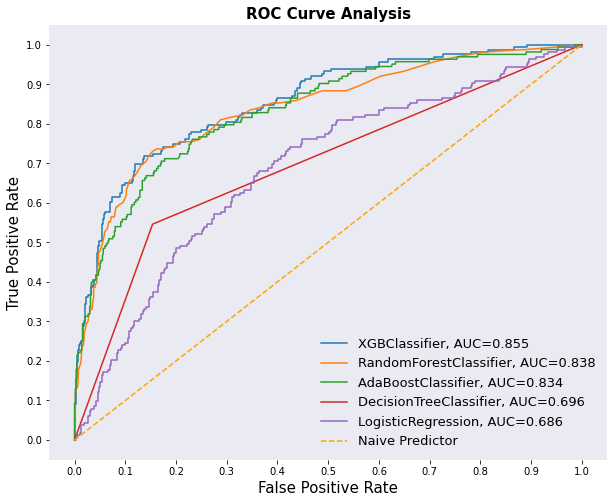

In [6]:
# Plot the figure
fig, ax = plt.subplots(1,1,figsize=(10,8))


for i in auc_table.index:
    plt.plot(auc_table.loc[i]['fpr'], 
             auc_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, auc_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--',label='Naive Predictor')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right',frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_facecolor('#EAEAF2')
plt.grid(b=False)
#plt.savefig('ROC2.png', format='png', transparent=True)
plt.show()

### Hyperpermeter Optimization

using all of training data

In [196]:
xgb_params = {
                 'max_depth':[i for i in range(3,8)],
                 'min_child_weight':[i for i in range(1,6)],
                'gamma':[i/10.0 for i in range(0,5)],
                'colsample_bytree':[i/10.0 for i in range(0,11)],
                'subsample':[i/10.0 for i in range(0,11)]
}

    
xgb_grid = GridSearchCV(XGBClassifier(learning_rate =0.1, n_estimators=500, max_depth=5,
                        min_child_weight=1, gamma=0, objective='binary:logistic', scale_pos_weight=1),
                        param_grid = xgb_params, scoring='roc_auc',n_jobs=-1, cv=5, verbose=2)

xgb_grid.fit(X_val, y_val)

Fitting 5 folds for each of 15125 candidates, totalling 75625 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 10.0min


KeyboardInterrupt: 

In [7]:
param_test1 = {
    'scale_pos_weight': [i for i in range(1,6)]
}

gsearch1 = GridSearchCV(
    estimator = XGBClassifier(learning_rate =0.01, n_estimators=1000, max_depth=5,
    min_child_weight=1, gamma=0, objective='binary:logistic', scale_pos_weight=1, seed=27,), 
    param_grid = param_test1, scoring='roc_auc',n_jobs=-1, cv=5)


gsearch1.fit(X_val, y_val)
gsearch1.best_params_, gsearch1.best_score_

({'scale_pos_weight': 1}, 0.8617525112923886)

In [8]:
param_test2 = {
    'max_depth':range(3,10,1),
    'min_child_weight':range(1,6,1)
}

gsearch2 = GridSearchCV(
    estimator = XGBClassifier(learning_rate =0.01, n_estimators=1000, max_depth=5,
    min_child_weight=1, gamma=0, objective='binary:logistic', scale_pos_weight=1, seed=27,), 
    param_grid = param_test2, scoring='roc_auc',n_jobs=-1, cv=5)


gsearch2.fit(X_val, y_val)
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 3, 'min_child_weight': 3}, 0.8630895397328352)

In [9]:
param_test3 = {
    'max_depth':[2,3,4],
    'min_child_weight':[2,3,4]
}

gsearch3 = GridSearchCV(
    estimator = XGBClassifier(learning_rate =0.01, n_estimators=1000, max_depth=5,
    min_child_weight=1, gamma=0, objective='binary:logistic', scale_pos_weight=1, seed=27,), 
    param_grid = param_test2, scoring='roc_auc',n_jobs=-1, cv=5)


gsearch3.fit(X_val, y_val)
gsearch3.best_params_, gsearch3.best_score_

({'max_depth': 3, 'min_child_weight': 3}, 0.8630895397328352)

In [10]:
param_test4 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.01, n_estimators=1000, max_depth=3,
    min_child_weight=3, gamma=0,objective='binary:logistic', scale_pos_weight=1,seed=27), 
    param_grid = param_test4, scoring='roc_auc',n_jobs=-1, cv=5)

gsearch4.fit(X_val, y_val)
gsearch4.best_params_, gsearch4.best_score_

({'gamma': 0.2}, 0.863182479221042)

In [11]:
param_test4 = {
    'subsample':[i/10.0 for i in range(0,11)]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.01, n_estimators=1000, max_depth=3,
    min_child_weight=3, gamma=0.2, objective='binary:logistic', scale_pos_weight=1,seed=27), 
    param_grid = param_test4, scoring='roc_auc',n_jobs=-1, cv=5)

gsearch4.fit(X_val, y_val)
gsearch4.best_params_, gsearch4.best_score_

({'subsample': 0.7}, 0.8649425508759426)

In [12]:
param_test5 = {
    'colsample_bytree':[i/10.0 for i in range(0,11)]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.01, n_estimators=1000, max_depth=3,
    min_child_weight=3, gamma=0.2, subsample=0.7, objective='binary:logistic', scale_pos_weight=1,seed=27), 
    param_grid = param_test5, scoring='roc_auc',n_jobs=-1, cv=5)

gsearch5.fit(X_val, y_val)
gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 1.0}, 0.8649425508759426)

In [6]:
# Save the optimized XGB model, fit to our training data
xgb_model = XGBClassifier(learning_rate =0.01, n_estimators=1000, max_depth=3,
    min_child_weight=3, gamma=.2, subsample=0.7, colsample_bytree=1.0,
    objective='binary:logistic', scale_pos_weight=1,seed=27).fit(X_val ,y_val)

In [14]:
# Pickle the model

import pickle 

with open('xgb_model.pickle', 'wb') as to_write:
    pickle.dump(xgb_model, to_write)


In [167]:
print(classification_report(y_test, xgb_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.79      0.48      0.60       407

    accuracy                           0.87      2000
   macro avg       0.84      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000



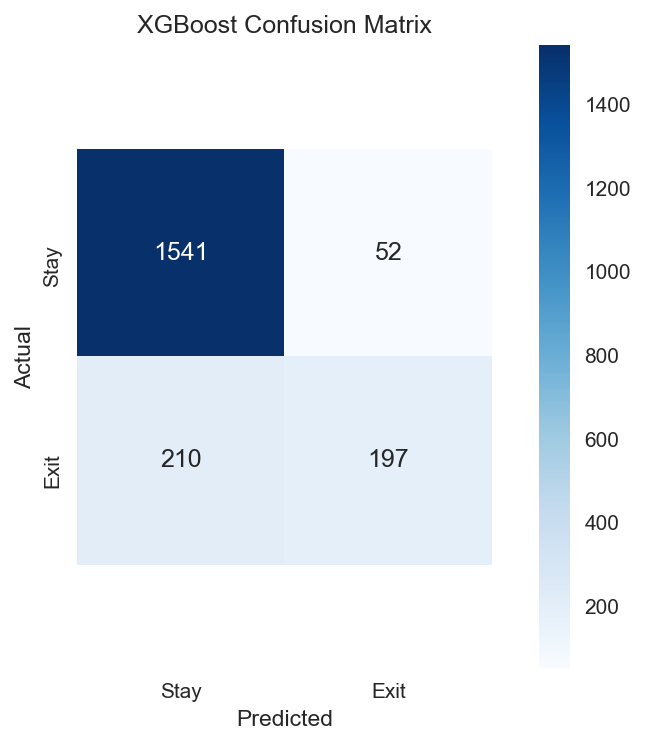

In [172]:
y_pred = xgb_model.predict(X_test)
xgb_confusion = confusion_matrix(y_test, y_pred)
plt.figure(dpi=150)
ax = sns.heatmap(xgb_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g',
           xticklabels=['Stay', 'Exit'],
           yticklabels=['Stay', 'Exit'])
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix');

/Users/joeorlich/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


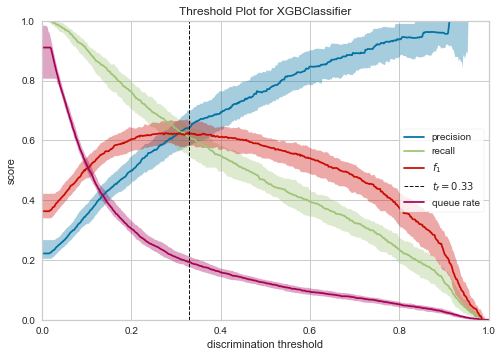

In [136]:
from yellowbrick.classifier import DiscriminationThreshold

test = XGBClassifier(learning_rate =0.01, n_estimators=1000, max_depth=3,
    min_child_weight=3, gamma=.2, subsample=0.7, colsample_bytree=1.0,
    objective='binary:logistic', scale_pos_weight=1,seed=27)

# Instantiate the classification model and visualizer
visualizer = DiscriminationThreshold(test)

visualizer.fit(X_val, y_val)
#plt.grid(b=None)
#plt.savefig('Threshold.png', format='png', transparent=True)
visualizer.show();

/Users/joeorlich/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/joeorlich/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0, flags=flags)


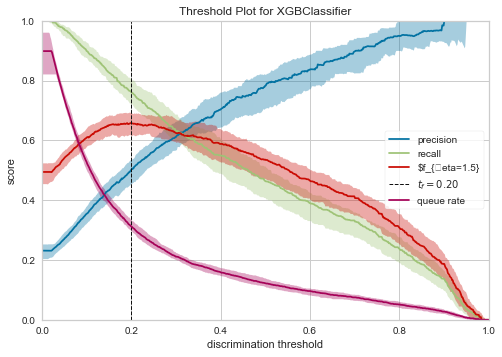

In [9]:
from yellowbrick.classifier import DiscriminationThreshold

test = XGBClassifier(learning_rate =0.01, n_estimators=1000, max_depth=3,
    min_child_weight=3, gamma=.2, subsample=0.7, colsample_bytree=1.0,
    objective='binary:logistic', scale_pos_weight=1,seed=27)

# Instantiate the classification model and visualizer
visualizer = DiscriminationThreshold(test, fbeta=1.5)

visualizer.fit(X_val, y_val)
#plt.grid(b=None)
#plt.savefig('Threshold.png', format='png', transparent=True)
visualizer.show();

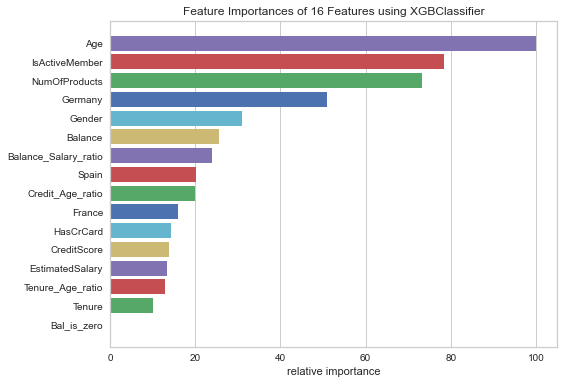

In [173]:
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.style import  set_palette

set_palette('sns_deep')

viz = FeatureImportances(xgb_model, labels=X_train.columns)
viz.fit(X_val, y_val)
viz.show();

In [59]:
precision_recall_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])[

array([0.20390782, 0.20350877, 0.20361083, ..., 1.        , 1.        ,
       1.        ])

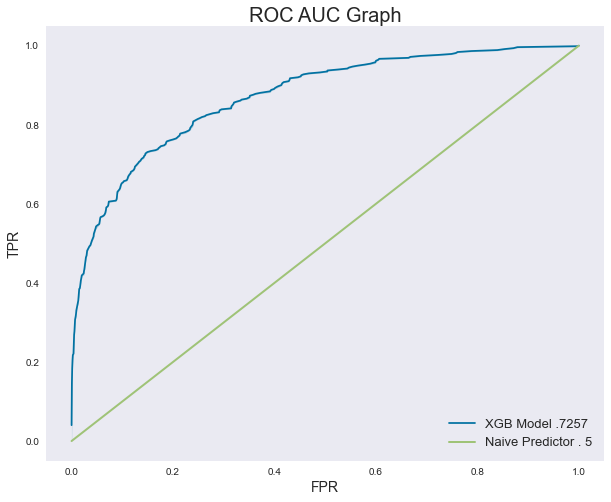

In [166]:
xgb_probs = xgb_model.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, xgb_probs)

fig, ax = plt.subplots(1,1, figsize=(10,8))
ax = sns.lineplot(x=fpr,y=tpr, label='XGB Model .7257')
plt.title('ROC AUC Graph',pad=4, fontsize=20)
plt.ylabel('TPR', fontsize=14)
plt.xlabel('FPR', fontsize=14)
plt.plot([0,1],[0,1], linewidth=2, label='Naive Predictor . 5')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.legend(prop={'size':13}, loc='lower right',frameon=False)

ax.set_facecolor('#EAEAF2')
plt.grid(b=False)
plt.show();

In [185]:
y_pred_probs = xgb_model.predict_proba(X_test)[:,1]
y_pred_probs_series = pd.Series(y_pred_probs, index=y_test.index)

In [137]:
def get_churned_bal(X,y_test, y_pred):
    balance_total = 36708330.81
    total_products = 614
    threshold_bal_df = pd.DataFrame(columns=['Threshold', 'Churned Balance %', 'Churned Products %', 'FPR'])
    for threshold in np.arange(0.01,1.01,.01):
        threshold_bal = 0
        threshold_prod = 0 
        FP = 0
        TN = 0
        FN = 0
        TP = 0 
        for index, value in y_pred.iteritems():
            if value > threshold:
                if y_test.loc[index] == 0:
                    FP +=1
                else:
                    threshold_bal += X.loc[index]['Balance']
                    threshold_prod += X.loc[index]['NumOfProducts']
                    TP+=1
            else:
                if y_test.loc[index] == 0:
                    TN+=1
                else:
                    FN+=1
        bal_ratio = threshold_bal/balance_total
        FPR = FP/(FP+TN)
        prod_ratio = threshold_prod/total_products
        threshold_bal_df = threshold_bal_df.append({'Threshold':threshold, 'Churned Balance %':bal_ratio,
                                                    'Churned Products %': prod_ratio, 'FPR':FPR}, ignore_index=True)
    return threshold_bal_df

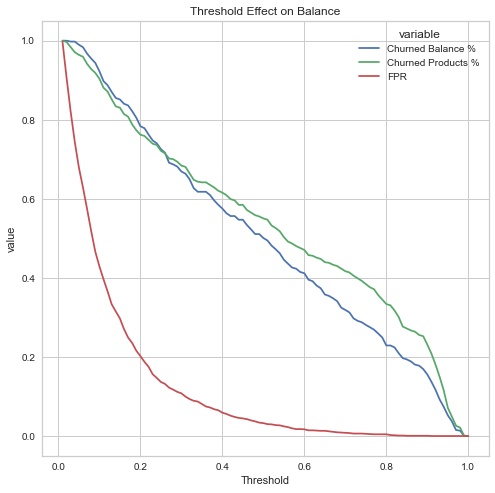

In [184]:
threshold_effects = get_churned_bal(X_test, y_test, y_pred_probs_series)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax = sns.lineplot(x='Threshold', y='value', hue='variable', data= pd.melt(threshold_effects, 'Threshold'))
ax.set_title('Threshold Effect on Balance');

              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1593
           1       0.49      0.76      0.60       407

    accuracy                           0.79      2000
   macro avg       0.71      0.78      0.73      2000
weighted avg       0.84      0.79      0.81      2000



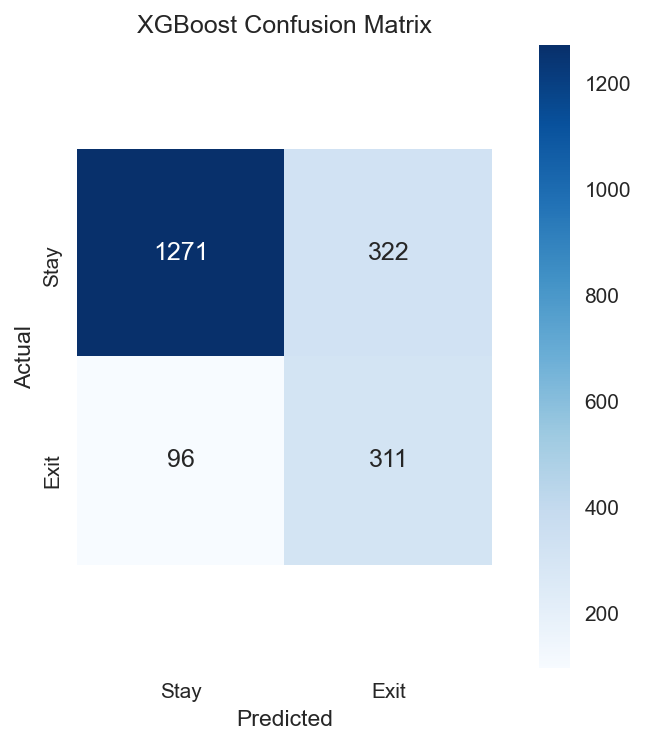

In [179]:
threshold = 0.2
y_pred = (xgb_model.predict_proba(X_test)[:, 1] > threshold).astype('float')
print(classification_report(y_test,y_pred))
plt.figure(dpi=150)
ax = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, annot=True, square=True, fmt='g',
           xticklabels=['Stay', 'Exit'],
           yticklabels=['Stay', 'Exit'])
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix');